# Prediction of housing price in California

In this project, we will analyze the California Housing Prices dataset from the StatLib repository2. This dataset was based on data from the 1990 California census. The final goal is to build a Machine Learning model capable to predict prices of houses for the considered region. This is a typical regression problem.

The project consists into four parts:
1. Get the data and the first insight. Create training and test datasets
2. Data wrangling: correct problems in data and prepare data for training the Machine Learning model
3. Train several Machine Learning models and select the most accurate one
4. Fine tuning of the selected Machine Learning model

## Get the dataset and first insights. Building of training and test datasets

In [1]:
# Import packages for data analysis
import os    # OS module provides the interface with the operating system and allows to use it
import tarfile
from six.moves import urllib
import pandas as pd     # Pandas: python library for large data manipulation and analysis. 
                        # Dataset will be saved as Pands dataset
import numpy as np
import matplotlib.pyplot as plt

# this command is very important in Jupyter: figures must be showed directly in the notebook!!!
%matplotlib inline

### Load data into Pandas' dataframe and check structure

In [2]:
# step 1: acquire dataset
data_path='C:/Users/jacopo/Desktop/Deep Learning/handson-ml-master/datasets/housing/housing.csv'
dataset = pd.read_csv(data_path)   # dataset as pandas dataset

print('Info and Histogram of the original dataset loaded. \n')
print('- each instance represents a district (small area of California)\n')
print('- household = family \n')
print('GOAL: predict median house value \n')

dataset.info()

# each instance represents a district (small area of California)
# houshold = Family

# detailed info about each attribute
dataset.describe()

Info and Histogram of the original dataset loaded. 

- each instance represents a district (small area of California)

- household = family 

GOAL: predict median house value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards. Notice that the total_bed rooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object, but since you loaded this data from a CSV file we know that it must be a text attribute, probably a categorical attribute. 

### Get first insights

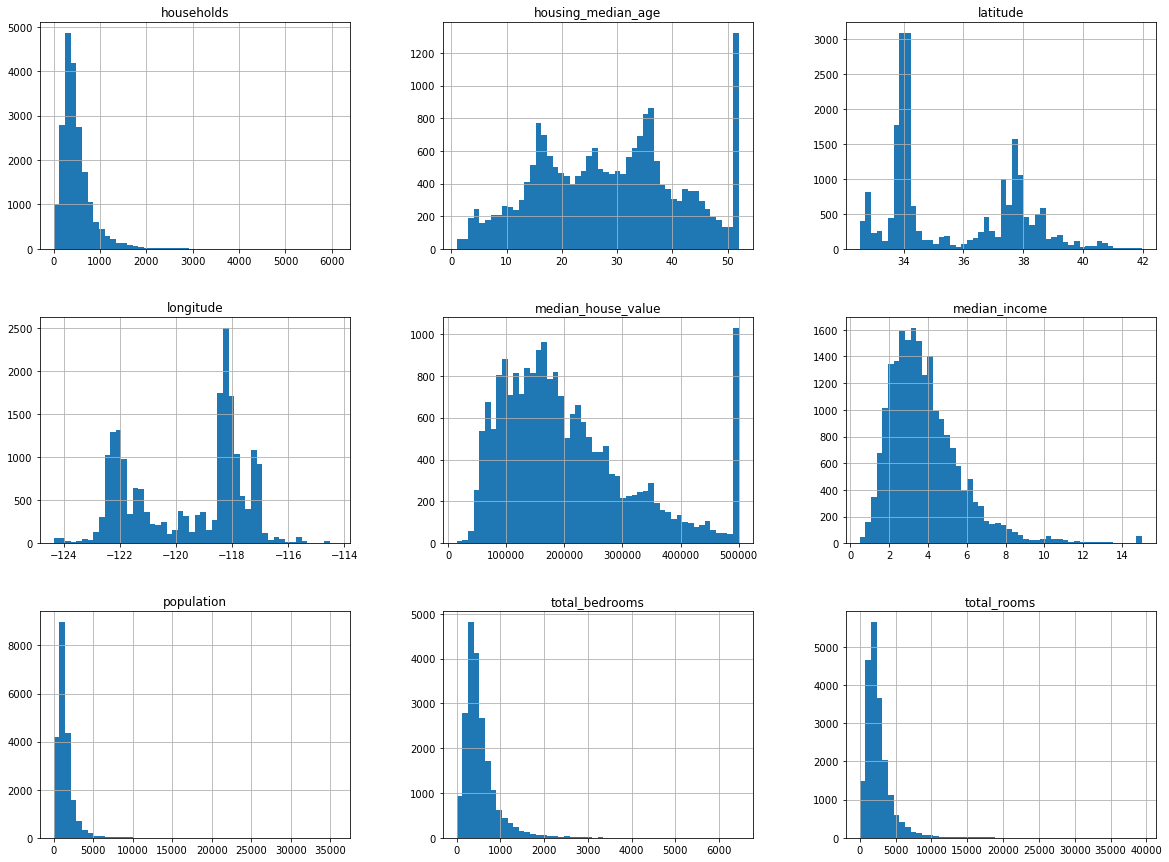

In [3]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

Previous histograms provide few information:
1. First, the median income attribute does not look like it is expressed in US dollars (USD). In fact, data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes.
2. The housing median age and the median house value are also capped. The latter may be a serious problem since it is our target attribute (your labels). The Machine Learning algorithms may learn that prices never go beyond that limit.
3. These attributes have very different scales. 
4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.


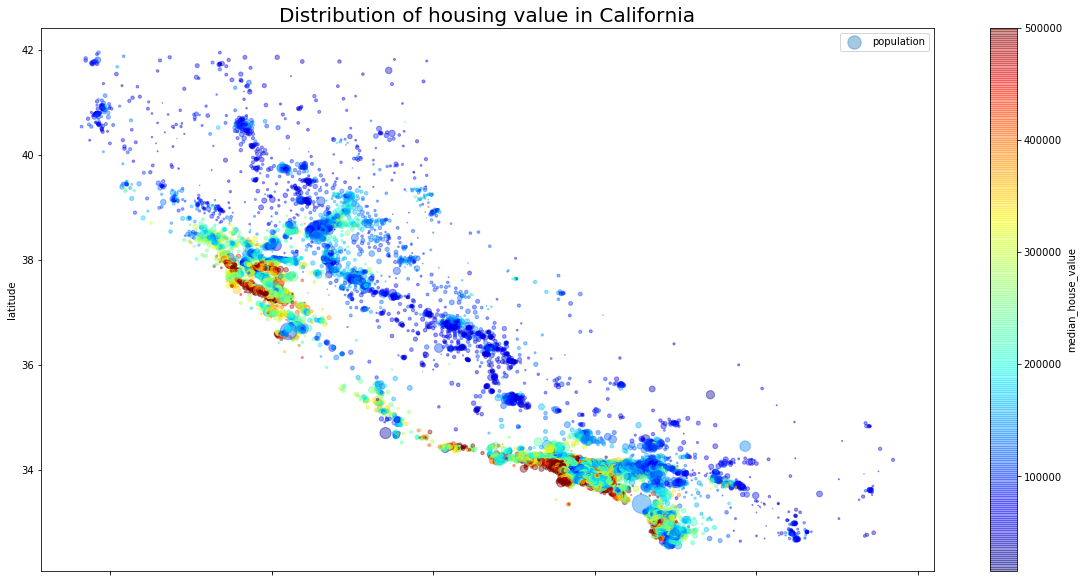

In [19]:
dataset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=dataset["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(20,10))
plt.legend()
plt.title("Distribution of housing value in California", fontsize=20)

This image tells us that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

In [ ]:
# # create new attributes
# print('Addition of the following attributes:')
# print('- rooms_per_household ')
# print('- bedrooms_per_room ')
# print('- population_per_household ')
# print('\n \n')

# dataset["rooms_per_household"] = dataset["total_rooms"]/dataset["households"]
# dataset["bedrooms_per_room"] = dataset["total_bedrooms"]/dataset["total_rooms"]
# dataset["population_per_household"]=dataset["population"]/dataset["households"] 
# # to delete dataset.drop(["attribute_name"], axis=1, inplace=True) 
# dataset.info()

# # new histogram
# dataset.hist(bins=50, figsize=(20,15))
# plt.show()

# # detailed info about each attribute
# dataset.describe()

### Check linear correlation through the Pearson's r coefficient

In [3]:
# check linear correlation through Pearson's r
corr_matrix = dataset.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D5C35B630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000024D5CDB7BE0>]], dtype=object)

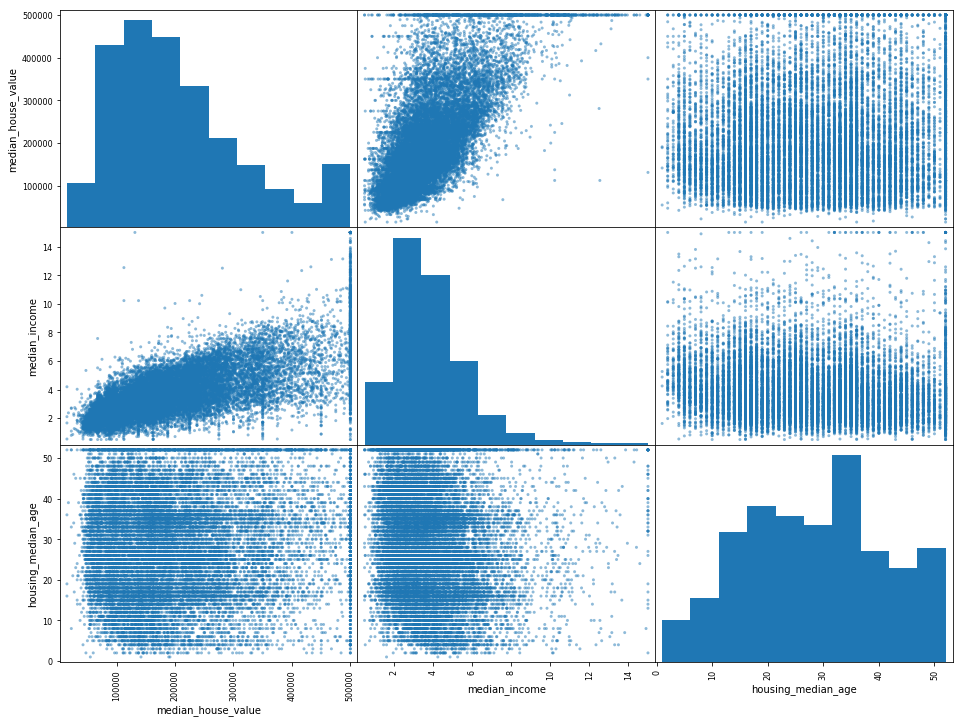

In [4]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income","housing_median_age"]
scatter_matrix(dataset[attributes], figsize=(16, 12))

The most promising attribute to predict the median house value is the median income since the Pearson's r = 0.688. The almost-linear relationship is also depicted in the previous figure.

Let's have a deeper look on the median income.

### Create training and test datasets

#### Select categories for statified sampling

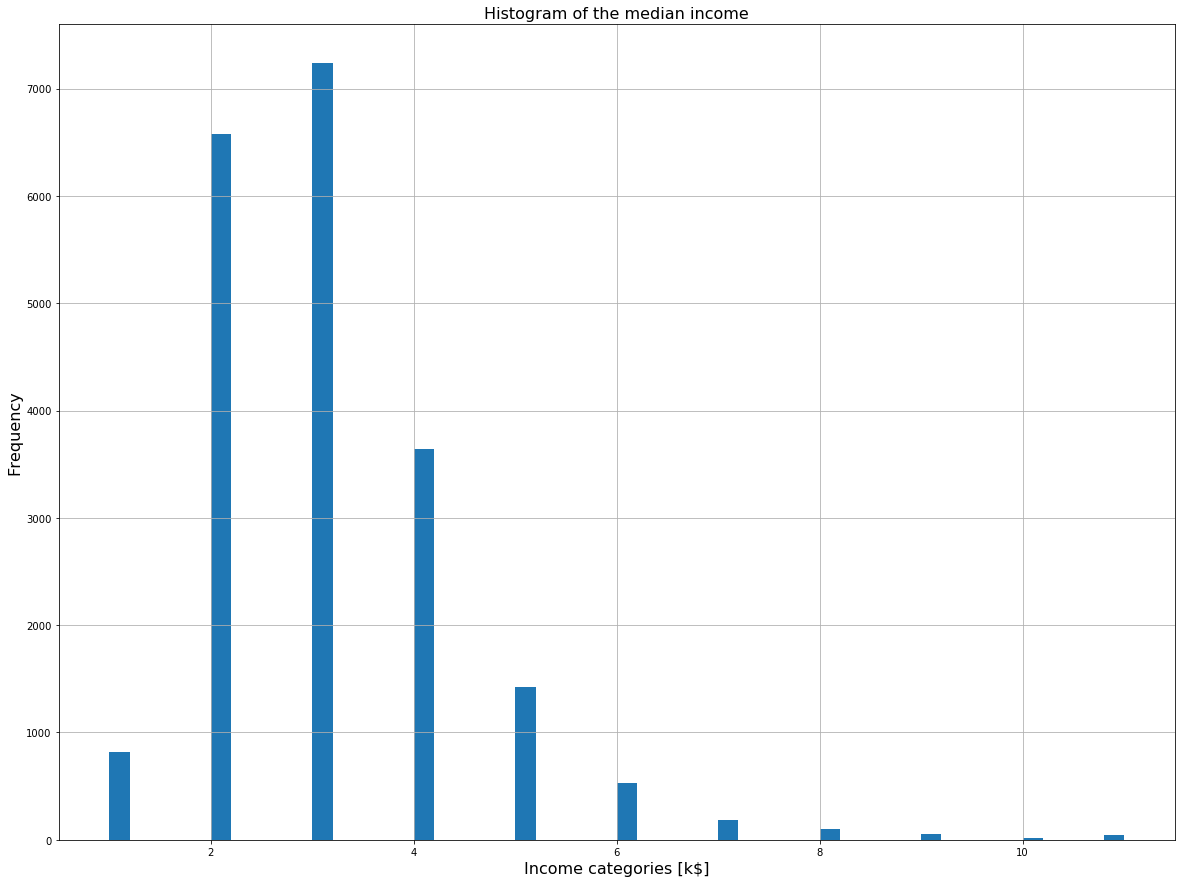

In [8]:
# the median income is the most relevant to predict the house value. 
# THerefore, we choose 'median_income' as attribute to create strata and sample
dataset["income_cat_for_StratSampling"] = np.ceil(dataset["median_income"] / 1.5)   # divide by 1.5 to have less strata and round with ceil
dataset["income_cat_for_StratSampling"].hist(bins=50, figsize=(20,15))
plt.xlabel("Income categories [k$]",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Histogram of the median income",fontsize=16)
plt.show()


The histogram of the median income shows that most of the incomes are limited up to 5 k$. Moreover, few distinct categories of income (1,2,3,4,5) can be clearly distinguished. Each of them has a certain frequency and these frequencies describe the population of median income. To perform statified sampling correctly to build the test dataset, we will use these categories of median income and their frequencies.

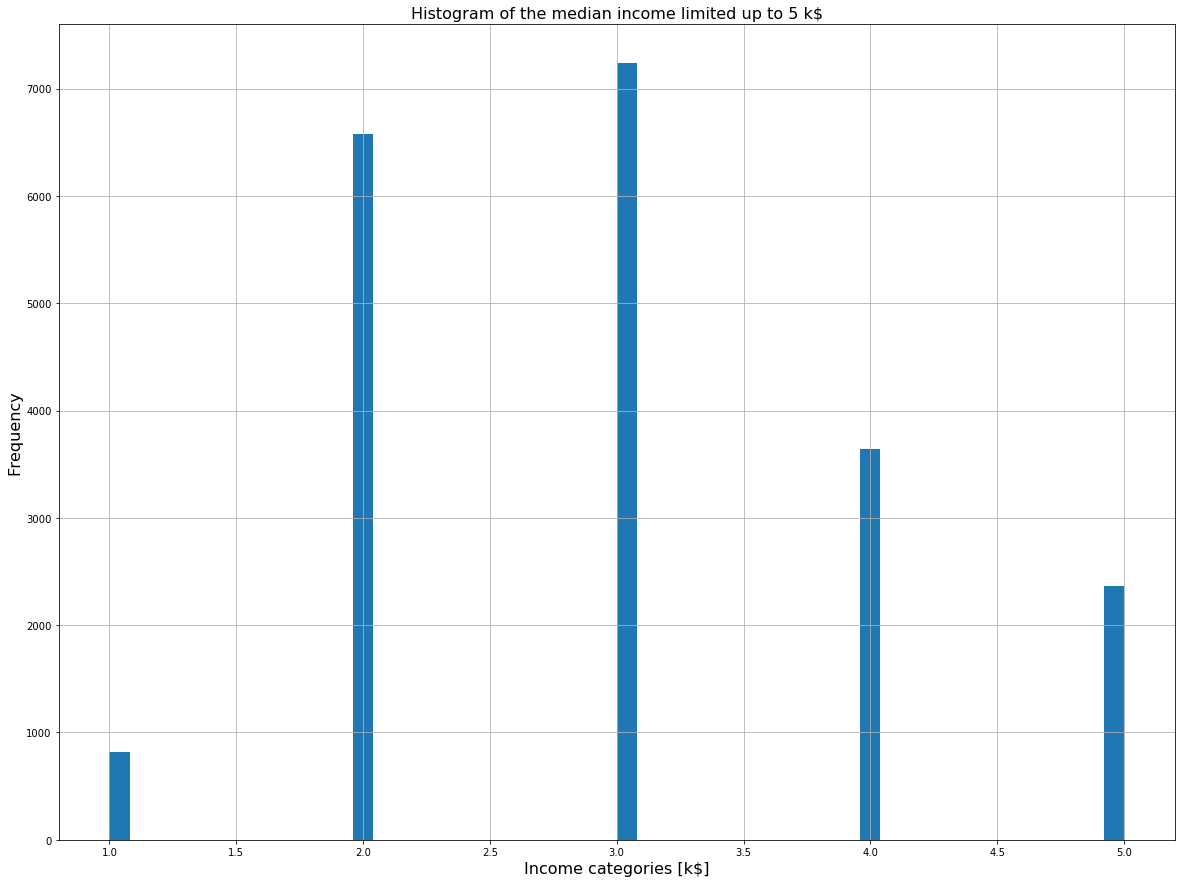

In [9]:
# by observing the histogram, we can observe that few data are greater that 5. 
# For simplifying the stratified sampling, we set all the values >5 as 5. 
# In fact, stratified sampling works better if population of the strata are of the same order of magnitude
dataset["income_cat_for_StratSampling"].where(dataset["income_cat_for_StratSampling"] < 5, 5.0, inplace=True)
dataset["income_cat_for_StratSampling"].hist(bins=50, figsize=(20,15))
plt.xlabel("Income categories [k$]",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Histogram of the median income limited up to 5 k$",fontsize=16)
plt.show()


#### Perform stratified sampling
Using the median income categories, we perform stratified sampling to generate test and training datasets. As frequently used, the random seed for each subsampling is 42.

In [7]:
# perform stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # n_splits: number of slitted dataset; test_size: size of test set; random_state=seed for generating random indexes in each stratum
for train_index, test_index in split.split(dataset, dataset["income_cat_for_StratSampling"]):    # split(dataset to split, attribute divided in strata that determines the stratified sampling)    
    dataset_train = dataset.loc[train_index]
    dataset_test = dataset.loc[test_index]


# delete attribute used to perform stratified sampling
dataset_test.drop(["income_cat_for_StratSampling"], axis=1, inplace=True) 
dataset_train.drop(["income_cat_for_StratSampling"], axis=1, inplace=True) 
dataset.drop(["income_cat_for_StratSampling"], axis=1, inplace=True)

# separate attributes from the attribute that must be predicted!!
dataset_test_Xattributes = dataset_test.drop(["median_house_value"], axis=1) 
dataset_test_Ylabel = dataset_test["median_house_value"].copy()

dataset_train_Xattributes = dataset_train.drop(["median_house_value"], axis=1) 
dataset_train_Ylabel = dataset_train["median_house_value"].copy()

dataset_train_Xattributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Data wrangling and preparation for Machine Learning

At this point, we must prepare data for being used by a Machine Learning model. In particular, we perform:
1. Find missing values and fill them with the median value (in fact, missing values are few and belong to the total_bedrooms field).
2. Rescale scaled fields
3. We create new fields: rooms_per_household, population_per_household and bedrooms_per_room
4. Convert text attributes of Ocean Proximity to numerical values using the one hot encoding method. This is necessary as many Machine Learning models require numeric inputs only.

To do this, we will build a scikit-learn's pipeline.

In [10]:
# STEP 4: prepare data for machine learning
      
# Scikit-Learn provides the class Pipeline, which executes automatically a list of Scikit-Learn's methods
# All the methods (except for the last one) must be transformers (they must execute fit_transform()).
# The last method can be predictor (fit_predict()) or transformer (fit_transform())
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion  # Transformer that concatenates results of multiple transformer objects

# Import classes for preparing data for ML system
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Standard usage of transformer imputer without pipeline: 
    # imputer = Imputer(strategy="median") # substitute missing values with median of the dataset
    # dataframe_transformed_numpy = imputer.fit_transform(dataset_num4imputer)  # substitute missing values with mean. return a numpy array


# Pipeline executes a list of transformers, which require numerical database only. Therefore I create a copy of the dataset without text attributes
dataset_train_numerical = dataset_train_Xattributes.drop(["ocean_proximity"], axis=1) 
num_attribs = list(dataset_train_numerical)    # attributes with numerical values only
cat_attribs = ["ocean_proximity"]        # attributes with text values only


from sklearn.base import BaseEstimator, TransformerMixin    # required to define custom transformer classes
# BaseEstimator: automatically creates 
# TransformerMixin: transformer requires fit(), transform() and fit_transform() methods. TransformerMixin allows to define fit() and transform() only, since it generates automatically fit_transform()

# transformer that selects certain columns (=attributes) of the dataset
class DataSelector(BaseEstimator, TransformerMixin):  # BaseEstimator & TransformerMixin are two basic classes required to build transformers/predictors (class inheritance)
    
    def __init__(self, attribute_names):  # constructor
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):   # fit method
        return self
    
    def transform(self, X):     # transform method
        return np.c_[X[self.attribute_names].values]
    
class CombineAttribute(BaseEstimator, TransformerMixin):
    rooms_ix = 3
    bedrooms_ix = 4
    population_ix = 5
    household_ix = 6
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):   # fit method
        return self
    
    def transform(self,X,y=None):
        rooms_per_household = X[:, self.rooms_ix] / X[:, self.household_ix]
        population_per_household = X[:, self.population_ix] / X[:, self.household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
# Pipeline for numerical attributes: create new attributes, fill missing attributes, standard scaling
pipeline_num_data = Pipeline([('selector_columns',DataSelector(num_attribs)),   # here num_attribs is hyperparameter
                              ('imputer',Imputer(strategy="median")),
                              ('combine_attributes',CombineAttribute()),
                              ('std_scale',StandardScaler())
                            ])

# Pipeline that performs one-hot encoding
from sklearn.preprocessing import LabelBinarizer   # for one-hot encoding
OneHot_pipeline = Pipeline([('selector_columns',DataSelector(cat_attribs)),
                           ('One_Hot_Encoding',LabelBinarizer())
                           ])

# Merge results of multiple transformers (NB Pipelines are treated as transfomers)
transformer_list=[("pipeline_for_numerical_attributes", pipeline_num_data), ("pipeline_for_one_Hot", OneHot_pipeline)]
full_pipeline = FeatureUnion(transformer_list)

# test single pipelines
#dataset_num_transformed = pipeline_num_data.fit_transform(dataset_train_Xattributes)
#dataset_num = pd.DataFrame(dataset_train_Xattributes)
#dataset_num.describe()

#


# call full pipeline
# dataset_prepared_numpy = full_pipeline.fit_transform(dataset)


Prepare data for Machine Learning algorithm (Pipeline):
- fill missing values 
- rescale values 
- convert text attributes to numerical values 

 



## Training of Machine Learning models

At this point, data are ready to be used by a Machine Learning model for training. Since, in general, it is hard to decide a priori which is the best prediction model for a problem, we will consider and train the following models:
1. Linear regression
2. Decision Tree
3. Random Forest
4. Support Vector Machine SVM

After training, the performance of each model will be evaluated using the cross-validation approach on the training set. Reference performance metric is the Root Mean Sqare Error RMSE.

### Linear regression

In [38]:
# Step 5: try some ML models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# function to display results from cross validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
# prepare training set by calling full pipeline
dataset_train_prepared_Xattributes_numpy = full_pipeline.fit_transform(dataset_train_Xattributes)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(dataset_train_prepared_Xattributes_numpy, dataset_train_Ylabel)

# rmse on redicted values
dataset_predictions = lin_reg.predict(dataset_train_prepared_Xattributes_numpy)
lin_mse = mean_squared_error(dataset_train_Ylabel, dataset_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE:", lin_rmse)

# cross validation on the training dataset
scores = cross_val_score(lin_reg,dataset_train_prepared_Xattributes_numpy,dataset_train_Ylabel,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

RMSE: 68628.1981985
Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


### Decision Tree

In [39]:
# regression using Decision Tree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(dataset_train_prepared_Xattributes_numpy, dataset_train_Ylabel)

# rmse
dataset_predictions = tree_reg.predict(dataset_train_prepared_Xattributes_numpy)
tree_mse = mean_squared_error(dataset_train_Ylabel, dataset_predictions)
tree_rmse = np.sqrt(tree_mse)
print("RMSE:", tree_rmse)

# cross validation on the training dataset
scores = cross_val_score(tree_reg,dataset_train_prepared_Xattributes_numpy,dataset_train_Ylabel,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

RMSE: 0.0
Scores: [ 70058.58908282  66450.74829675  69991.28289436  68775.45184627
  70356.50373526  73709.27974614  71389.89050234  69997.4258879
  77045.76693804  70282.92843729]
Mean: 70805.7867367
Standard deviation: 2704.58546695


### Random Forest

In [40]:
# regression using Random Forest
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(dataset_train_prepared_Xattributes_numpy, dataset_train_Ylabel)

# rmse
dataset_predictions = forest_reg.predict(dataset_train_prepared_Xattributes_numpy)
forest_mse = mean_squared_error(dataset_train_Ylabel, dataset_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE:", forest_rmse)

# cross validation on the training dataset
scores = cross_val_score(forest_reg,dataset_train_prepared_Xattributes_numpy,dataset_train_Ylabel,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

RMSE: 22338.6561866
Scores: [ 51700.35165758  50717.93133576  52336.95385426  55903.92543771
  52017.98739331  56014.07616166  51994.34172954  50805.11759437
  55093.15342126  53655.72404679]
Mean: 53023.9562632
Standard deviation: 1909.25964148


### SVM

In [44]:
# Support Vector Machine
from sklearn.svm import SVR
svr_reg = SVR()
svr_reg.fit(dataset_train_prepared_Xattributes_numpy, dataset_train_Ylabel)

# rmse
dataset_predictions = svr_reg.predict(dataset_train_prepared_Xattributes_numpy)
svr_mse = mean_squared_error(dataset_train_Ylabel, dataset_predictions)
svr_rmse = np.sqrt(svr_mse)
print("RMSE:", svr_rmse)

# cross validation on the training dataset
scores = cross_val_score(svr_reg,dataset_train_prepared_Xattributes_numpy,dataset_train_Ylabel,scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)
display_scores(svr_rmse_scores)

RMSE: 118577.433564
Scores: [ 111393.33263237  119546.71049753  116961.00489445  120449.0155974
  117622.20149716  122303.76986818  117640.09907103  121459.63518806
  120348.51364519  118025.61954959]
Mean: 118574.990244
Standard deviation: 2934.13294331


Cross-validation shows that Random Forest provides the best estimation of the hausing price since it has lowest RMSE and lowest scores from cross-validation.

## Fine tuning of the Random Forest model

Now we apply grid search to optimize the hyperparameters of the selected model. In particular, we optimize the following parameters:
1. Number of weak estimators
2. BootStrap
3. Max features

In [46]:
# Fine - tuning of the selected ML model
# the best ML model is forest tree. We will perform fine tuning on it

from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error')
grid_search.fit(dataset_train_prepared_Xattributes_numpy, dataset_train_Ylabel)
grid_search.best_params_


{'max_features': 6, 'n_estimators': 30}

## Test trained model on test dataset

This is the final step in this project. Let's see the performance of the trained Random Forest on the test dataset.

In [47]:
# prepare test dataset
dataset_test_prepared_Xattributes_numpy = full_pipeline.fit_transform(dataset_test_Xattributes)

# define ML system with tuned hyperparameters
MLsystem_forest_reg = grid_search.best_estimator_
MLsystem_forest_reg.fit(dataset_test_prepared_Xattributes_numpy, dataset_test_Ylabel)

# rmse
dataset_predictions = MLsystem_forest_reg.predict(dataset_test_prepared_Xattributes_numpy)
MLsystem_mse = mean_squared_error(dataset_test_Ylabel, dataset_predictions)
MLsystem_rmse = np.sqrt(MLsystem_mse)
print("RMSE:", MLsystem_rmse)

# cross validation on the training dataset
scores = cross_val_score(MLsystem_forest_reg,dataset_test_prepared_Xattributes_numpy,dataset_test_Ylabel,scoring="neg_mean_squared_error", cv=10)
MLsystem_rmse_scores = np.sqrt(-scores)
display_scores(MLsystem_rmse_scores)

RMSE: 20724.9994527
Scores: [ 50024.84043711  56999.02656684  57746.61692538  51391.75034002
  54720.28728777  50974.76376218  53994.9456794   50252.58769512
  57602.81812116  47476.79161659]
Mean: 53118.4428432
Standard deviation: 3422.15234894


The Random Forest performs slightly worse than with the training dataset. This is normal.

**Now we have a Machine LEarning model capable to predict housing price in California!**